In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# read file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f :
    ball_positions = pickle.load(f)

In [6]:
ball_positions

[{},
 {1: [894.8911743164062,
   615.922119140625,
   911.4618530273438,
   634.1310424804688]},
 {},
 {},
 {},
 {},
 {1: [822.3594360351562,
   687.91552734375,
   836.7511596679688,
   703.4284057617188]},
 {},
 {1: [797.091064453125, 719.0078125, 813.2623901367188, 738.7972412109375]},
 {1: [777.176025390625, 741.64013671875, 798.9703369140625, 765.973388671875]},
 {1: [771.1461181640625,
   758.9022216796875,
   787.411376953125,
   776.091064453125]},
 {1: [777.7402954101562,
   717.7176513671875,
   796.3851928710938,
   738.9812622070312]},
 {},
 {1: [795.3804931640625, 646.8876342773438, 812.671875, 667.3201904296875]},
 {1: [802.47216796875, 607.1044921875, 822.41015625, 627.2792358398438]},
 {1: [814.4690551757812,
   569.09326171875,
   830.9928588867188,
   586.9667358398438]},
 {1: [818.367919921875,
   551.043701171875,
   836.6458740234375,
   572.2064819335938]},
 {1: [826.4932250976562,
   521.93994140625,
   843.6637573242188,
   538.976318359375]},
 {},
 {},
 {},
 {}

In [11]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
#Interpolates missing values in the DataFrame using linear interpolation (interpolate) and
# fills any remaining missing values with the next valid observation (bfill).
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()


In [12]:
df_ball_positions

,x1,y1,x2,y2
0,894.891174,615.922119,911.461853,634.131042
1,894.891174,615.922119,911.461853,634.131042
2,880.384827,630.320801,896.519714,647.990515
3,865.878479,644.719482,881.577576,661.849988
4,851.372131,659.118164,866.635437,675.709460
...,...,...,...,...
209,1184.624878,247.886551,1199.126221,265.256287
210,1184.528076,232.968979,1196.005493,245.350479
211,1183.764526,226.167221,1196.990967,241.377060
212,1180.184326,214.059052,1194.869507,229.378479


## Calculate Midpoint and Rolling Mean:



In [14]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

> ####  Computes the midpoint of the ball's y-coordinates and a rolling mean of this midpoint over a window of 5 frames to smooth out the variations.

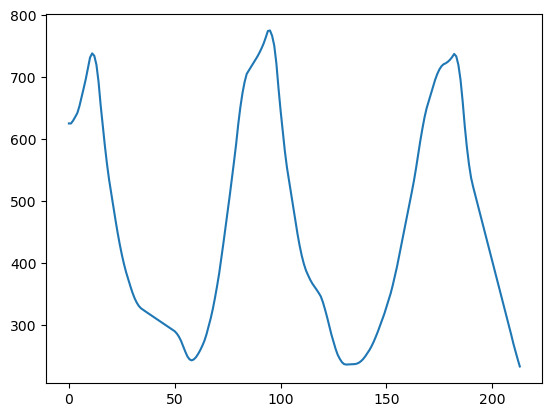

In [15]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

## Calculate Change in Midpoint:



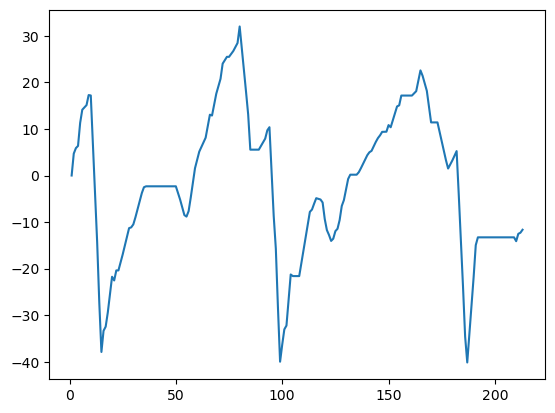

In [18]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()  
plt.plot(df_ball_positions['delta_y'])

> #### Computes the difference between consecutive rolling means to detect changes in the ball's position and plots this change.

## Detecting Ball Hits :



In [19]:
df_ball_positions['ball_hit'] = 0

In [27]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

C:\Users\user\AppData\Local\Temp\ipykernel_8036\2321204345.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_8036\2321204345.py:18: SettingWithCopyWarnin

In [22]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
0,894.891174,615.922119,911.461853,634.131042,625.026581,625.026581,NaN,0
1,894.891174,615.922119,911.461853,634.131042,625.026581,625.026581,0.000000,0
2,880.384827,630.320801,896.519714,647.990515,639.155658,629.736273,4.709692,0
3,865.878479,644.719482,881.577576,661.849988,653.284735,635.623389,5.887115,0
4,851.372131,659.118164,866.635437,675.709460,667.413812,641.981473,6.358085,0
...,...,...,...,...,...,...,...,...
209,1184.624878,247.886551,1199.126221,265.256287,256.571419,283.123520,-13.276051,0
210,1184.528076,232.968979,1196.005493,245.350479,239.159729,269.020341,-14.103178,0
211,1183.764526,226.167221,1196.990967,241.377060,233.772141,256.494855,-12.525486,0
212,1180.184326,214.059052,1194.869507,229.378479,221.718765,244.213905,-12.280951,0


In [24]:
df_ball_positions[df_ball_positions["ball_hit"] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.740295,717.717651,796.385193,738.981262,728.349457,738.168527,6.535498,1
58,925.612244,240.634897,938.722815,254.141299,247.388098,242.420783,-1.578134,1
95,624.485687,749.125549,641.132782,766.333832,757.729691,775.176547,0.857779,1
131,716.041077,229.172249,729.199921,242.913330,236.042789,235.685427,-0.737811,1
182,1295.967285,740.126038,1314.577393,758.677185,749.401611,737.326035,5.244312,1


In [26]:
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions["ball_hit"] == 1].index.tolist()